As one of the identified models for our baseline comparison, Random Forrest was selected due to its its effectiveness in handling large datasets with higher dimensionality. It's known for its robustness against overfitting, importance in feature selection, and good generalization capabilities.

RF Models have been used in the types of data we are exploring.

I will run a baseline model for comparison. In order to enhance the typical approach of using random forest, I will incorporate unsupervised ML techniques to add to the feature space, and hopefully enhance the performance of the model

In [1]:
# Some may be redundant for certain. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, roc_auc_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA


In [2]:
data = pd.read_csv('model_data.csv')
holder = data.copy()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686195 entries, 0 to 686194
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  686195 non-null  int64  
 1   loanAmnt            686195 non-null  float64
 2   term                686195 non-null  int64  
 3   interestRate        686195 non-null  float64
 4   installment         686195 non-null  float64
 5   employmentTitle     686195 non-null  float64
 6   employmentLength    686195 non-null  float64
 7   homeOwnership       686195 non-null  int64  
 8   annualIncome        686195 non-null  float64
 9   verificationStatus  686195 non-null  int64  
 10  issueDate           686195 non-null  object 
 11  isDefault           686195 non-null  int64  
 12  purpose             686195 non-null  int64  
 13  postCode            686195 non-null  float64
 14  regionCode          686195 non-null  int64  
 15  dti                 686195 non-nul

In [4]:
# Data preprocessing

data.rename(columns={"earliesCreditLine": "earliest_creditline"}, inplace=True)

data.issueDate = pd.to_datetime(data.issueDate)  # 2014-07-01

data.endDate = pd.to_datetime(data.endDate)# 2020-10-01 

data.earliest_creditline = pd.to_datetime(data.earliest_creditline) # May-2006

/var/folders/fq/ff13_72j5cj69n484hgdxvs80000gn/T/ipykernel_5569/4030306364.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.earliest_creditline = pd.to_datetime(data.earliest_creditline) # May-2006


In [7]:
# Select features for clustering - excluding 'id', 'isDefault', and any non-numeric or irrelevant columns
# will also use in classifier

features_for_clustering = ['loanAmnt', 'term', 'interestRate', 'installment',
       'employmentTitle', 'employmentLength', 'homeOwnership', 'annualIncome',
       'verificationStatus', 'purpose', 'postCode',
       'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow',
       'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal',
       'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType',
       'title', 'policyCode', 'avg_GDP',
       'avg_UNRATE', 'avg_CPIAUCSL', 'num_subGrade', 'num_grade']

### Normalize Data

Random Forest is not sensitive to scale, so traditionally, this would not be a part of the process. However, since I wanted to utilize knn, it requires normalization. To be able to compare the baseline model to the model with the clustering labels, the data had to be handled similarly

In [8]:
# Normalize features for KNN comparison

scaler = StandardScaler()
df_scaled = scaler.fit_transform(data[features_for_clustering])

# Convert scaled features back to a DataFrame 
df_scaled = pd.DataFrame(df_scaled, columns=features_for_clustering)

In [9]:
df_scaled

,loanAmnt,term,interestRate,installment,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,...,totalAcc,initialListStatus,applicationType,title,policyCode,avg_GDP,avg_UNRATE,avg_CPIAUCSL,num_subGrade,num_grade
0,2.316170,1.743984,1.305425,1.795610,-0.659852,-1.142846,2.076259,0.452473,1.336247,-0.306764,...,0.148608,-0.795916,-0.139578,-0.194561,0.0,-0.169185,-0.418754,-0.262287,-1.781555,-1.741691
1,-0.309941,1.743984,0.779169,-0.564278,-0.353188,0.540275,-0.905896,-0.055402,1.336247,-0.736970,...,0.148608,-0.795916,-0.139578,-0.194705,0.0,0.514435,0.498012,0.503899,-0.948356,-0.969507
2,-0.424120,-0.573400,-1.244736,-0.401355,-0.205066,1.101315,0.585182,0.565334,0.026390,0.983852,...,0.231639,1.256414,-0.139578,-0.194127,0.0,-0.133868,-0.664923,-0.308239,1.399749,1.347044
3,-0.424120,-0.573400,-1.092891,-0.387306,-0.157441,0.259755,-0.905896,-0.549169,1.336247,3.134880,...,2.224373,1.256414,-0.139578,-0.193261,0.0,0.933616,-0.198704,0.908041,1.475494,1.347044
4,-1.446020,-0.573400,-1.155293,-1.456070,1.097008,0.820795,-0.905896,-0.605600,-1.283467,-0.736970,...,-0.183514,-0.795916,-0.139578,-0.194705,0.0,-0.795361,0.116679,-0.859193,1.399749,1.347044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686190,1.174383,-0.573400,0.259152,1.576450,-0.636992,0.259755,0.585182,-0.083617,-1.283467,-0.736970,...,-0.847758,1.256414,-0.139578,-0.194705,0.0,0.583404,-1.240840,0.365422,-0.115158,-0.197324
686191,0.260952,-0.573400,-1.111612,0.325801,-0.377553,1.101315,-0.905896,0.297289,1.336247,0.983852,...,1.394067,-0.795916,-0.139578,4.625016,0.0,-1.917937,2.008979,-1.471084,1.399749,1.347044
686192,-0.995014,-0.573400,0.017864,-0.926181,-0.637745,1.101315,0.585182,-0.182371,1.336247,-0.736970,...,0.895884,1.256414,-0.139578,-0.194705,0.0,-0.035409,-0.760909,-0.204078,-0.190903,-0.197324
686193,0.512146,-0.573400,-1.315458,0.555012,-0.661503,1.101315,-0.905896,0.254966,1.336247,0.983852,...,0.978914,1.256414,-0.139578,-0.194127,0.0,-0.518247,-0.248982,-0.648877,1.399749,1.347044


Silhouette Score to Determine Best Number of Clusters

In [10]:
# Determine the optimal number of clusters using silhouette score

silhouette_scores = []
for n_clusters in range(2, 11):  # Test a range of k values to find the best
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, clusters)
    silhouette_scores.append(score)

best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Adjusting index to match the actual cluster number

/Users/ellisony/anaconda3/envs/work3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ellisony/anaconda3/envs/work3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ellisony/anaconda3/envs/work3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ellisony/anaconda3/envs/work3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

In [11]:
best_n_clusters

2

In [12]:
# Apply KMeans with the optimal number of clusters

kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(df_scaled)

# Optionally, add distances to cluster centroids as features
distances = kmeans.transform(df_scaled)
for i in range(best_n_clusters):
    data[f'cluster_{i}_distance'] = distances[:, i]

/Users/ellisony/anaconda3/envs/work3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
data

,id,loanAmnt,term,interestRate,installment,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,...,policyCode,endDate,avg_GDP,avg_UNRATE,avg_CPIAUCSL,num_subGrade,num_grade,cluster,cluster_0_distance,cluster_1_distance
0,0,35000.0,5,19.52,917.97,320.0,2.0,2,110000.0,2,...,1.0,2019-07-01,19510.161857,4.638095,244.072190,2.5,2,1,6.689328,5.084538
1,2,12000.0,5,16.99,298.17,31698.0,8.0,0,74000.0,2,...,1.0,2020-10-01,19923.215667,5.152381,249.167714,3.6,3,1,4.539059,2.791158
2,3,11000.0,3,7.26,340.96,46854.0,10.0,1,118000.0,1,...,1.0,2018-08-01,19531.501000,4.500000,243.766583,6.7,6,0,2.934803,5.018476
3,5,11000.0,3,7.99,344.65,51727.0,7.0,0,39000.0,2,...,1.0,2020-04-01,20176.490615,4.761538,251.855462,6.8,6,0,5.484002,6.863062
4,6,2050.0,3,7.69,63.95,180083.0,9.0,0,35000.0,0,...,1.0,2017-10-01,19131.816769,4.938462,240.102462,6.7,6,0,4.570383,7.033360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686190,799995,25000.0,3,14.49,860.41,2659.0,7.0,1,72000.0,0,...,1.0,2019-07-01,19964.887692,4.176923,248.246769,4.7,4,0,3.972243,4.019641
686191,799996,17000.0,3,7.90,531.94,29205.0,10.0,0,99000.0,2,...,1.0,2016-04-01,18453.539385,6.000000,236.033077,6.7,6,0,7.073050,8.090234
686192,799997,6000.0,3,13.33,203.12,2582.0,10.0,1,65000.0,2,...,1.0,2018-10-01,19590.991231,4.446154,244.459308,4.6,4,0,4.116093,4.320505
686193,799998,19200.0,3,6.92,592.14,151.0,10.0,0,96000.0,2,...,1.0,2018-02-01,19299.253583,4.733333,241.501167,6.7,6,0,4.950469,5.800358


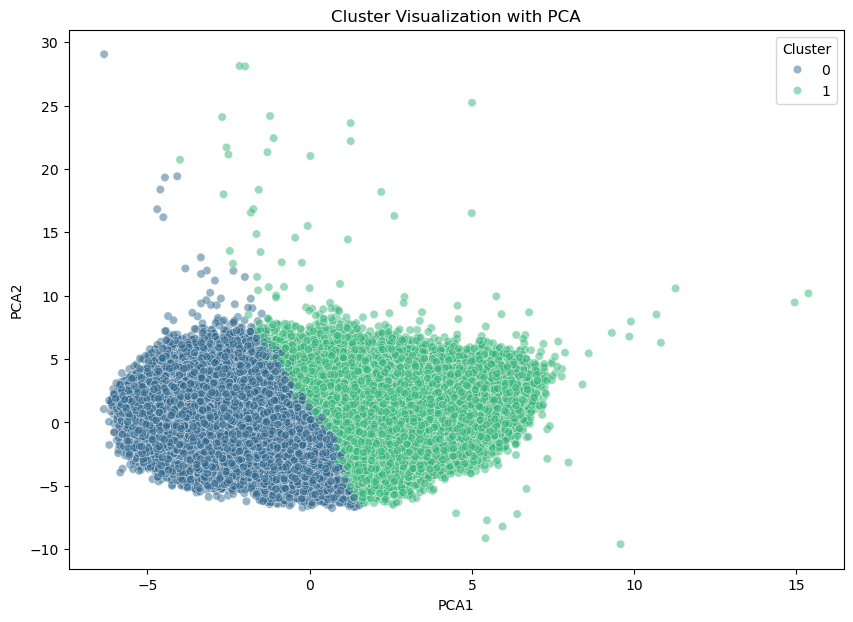

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce the data to 2 components for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Create a DataFrame with PCA results and cluster labels
df_pca = pd.DataFrame(data=df_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = data['cluster']

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', alpha=0.5)
plt.title('Cluster Visualization with PCA')
plt.show()

PCA Allows us to look at how our cluster breakdowns impact the 2 most important features. 

Initially, I wanted to iterate through values of k, and optimize. since data is very large, we settle on simply assigning k = 3, a standard value. The intention behind adding the clusters is to see if using an unsupervised clustering method to generate additional features can improve model performance.

###  Random Forest Classification

In [18]:
# Split Data

X = data.drop('isDefault', axis=1)  # features including the new cluster labels
y = data['isDefault']  # target variable

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



    Possibly Incorporate HyperParam tuning Into baseline Run, using GridSearch to optimize.

    Then incorporate optimal params in secondary run. 

In [19]:


# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train[features_for_clustering], y_train)

best_params = grid_search.best_params_

# Fit model using best parameters
rfc_best = RandomForestClassifier(**best_params, random_state=42)
rfc_best.fit(X_train[features_for_clustering], y_train)

# Predict and evaluate
y_pred = rfc_best.predict(X_test[features_for_clustering])
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Optimized Model Accuracy: {accuracy}")
print(f"Optimized Model ROC-AUC: {roc_auc}")

# Cross-validation
cv_scores = cross_val_score(rfc_best, X[features_for_clustering], y, cv=5, scoring='roc_auc')
print(f"CV ROC-AUC Score: {np.mean(cv_scores)}")

/Users/ellisony/anaconda3/envs/work3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimized Model Accuracy: 0.8082833596863865
Optimized Model ROC-AUC: 0.5188874422869618
CV ROC-AUC Score: 0.720893102366167


This performed worse than the iteration with 3 clusters. 